### Imports and Environment

In [1]:
import torch as th

In [2]:
import gymnasium as gym
from stable_baselines3 import DDPG
from stable_baselines3.common.noise import NormalActionNoise, OrnsteinUhlenbeckActionNoise

import numpy as np

import collections
import gymnasium as gym
import numpy as np
import os

import tqdm

from matplotlib import pyplot as plt
from typing import Any, List, Sequence, Tuple

import pickle

import path_datatype
import sys

from env import tradingEng

# Define environment
file_path = os.path.abspath("../MarketGeneratingFunctions/1.6kRunDemo.pkl")
with open(file_path,"rb") as fp:
    paths = pickle.load(fp)
env = tradingEng(paths)

/Users/isabellebyman/opt/anaconda3/envs/exjobb/lib/python3.13/site-packages/gymnasium/spaces/box.py:130: UserWarning: WARN: Box bound precision lowered by casting to float32
  gym.logger.warn(f"Box bound precision lowered by casting to {self.dtype}")


In [3]:
import importlib
import env
importlib.reload(env) 
env = env.tradingEng(paths)

In [4]:
len(paths) # still not the same length!!!

1600

# DDPG

In [150]:
from stable_baselines3.common.env_checker import check_env

check_env(env, warn=True, skip_render_check=True)

AssertionError: The observation returned by the `reset()` method does not match the data type (cannot cast) of the given observation space Box([  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0. -inf], [ 1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
 inf inf inf inf inf inf inf inf inf  1.  1.  1.  1.  1.  1.  1.  1.  1.
 inf], (37,), float32). Expected: float32, actual dtype: float64

### Making the Agent

In [125]:
n_actions = 18
action_noise = OrnsteinUhlenbeckActionNoise(mean = np.zeros(n_actions), sigma = 0.001*np.ones(n_actions), theta = 0.001)
model = DDPG("MlpPolicy", env, action_noise=action_noise, verbose=1, batch_size=25)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


### Training the Agent

In [126]:
Nruns = 10
model.learn(total_timesteps=252*10*Nruns, log_interval=2)
model.save("ddpg_fin")

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -0.0116  |
| time/              |          |
|    episodes        | 2        |
|    fps             | 234      |
|    time_elapsed    | 10       |
|    total_timesteps | 2344     |
| train/             |          |
|    actor_loss      | -0.397   |
|    critic_loss     | 0.000196 |
|    learning_rate   | 0.001    |
|    n_updates       | 1172     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1.17e+03 |
|    ep_rew_mean     | -0.0144  |
| time/              |          |
|    episodes        | 4        |
|    fps             | 162      |
|    time_elapsed    | 28       |
|    total_timesteps | 4688     |
| train/             |          |
|    actor_loss      | -0.573   |
|    critic_loss     | 0.000226 |
|    learning_rate   | 0.001    |
|    n_updates       | 3516     |
--------------

### Run a test

In [127]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs, info = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=True)  # replace with actual agent
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated or truncated
env.close()

print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

Example action taken: [array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1.,  1., -1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1.,
       -1., -1., -1., -1.,  1.], dtype=float32), array([-1

In [51]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

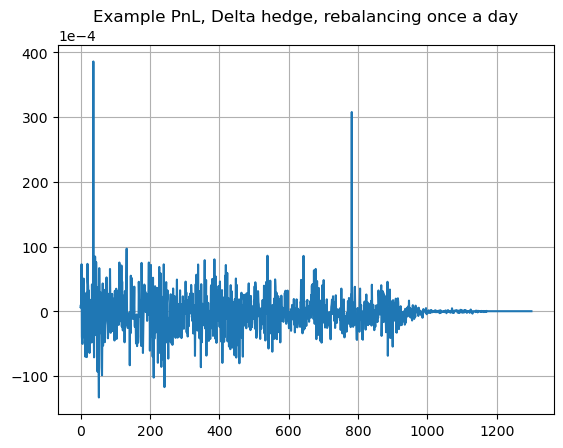

In [55]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[1])

In [53]:
np.percentile(pnl_tot[9], 5)

np.float64(-0.004446889275215954)

In [54]:
np.percentile(pnl_tot[1], 5)

np.float64(-0.004446889275215954)

# PPO

In [5]:
from stable_baselines3.common.monitor import Monitor
import os

log_dir = "./logs/"  # Define a log directory
os.makedirs(log_dir, exist_ok=True)  # Create it if it doesn't exist

env = Monitor(env, log_dir + "monitor.csv")  # Save log file

In [6]:
from stable_baselines3 import PPO

policy_kwargs = dict(activation_fn=th.nn.ReLU,
                     net_arch=dict(pi=[512,512], vf=[512,512]))
model = PPO("MlpPolicy", env, policy_kwargs=policy_kwargs,  verbose=1, batch_size=2048, n_steps=2048, gamma=0.99, learning_rate=3e-4)

# model = PPO("MlpPolicy", env, verbose=1, batch_size=64*4*5, n_steps=2048, gamma=0.99, learning_rate=3e-4) 

Using cpu device
Wrapping the env in a DummyVecEnv.


### Training the Agent

In [7]:
Nruns = 10
model.learn(total_timesteps=252*Nruns, log_interval=2) # exploration_fraction=0.2 Runs in total total_timesteps. After every n_steps, update the policy. Makes decision based on batch_size.
model.save("ppo_fin") # 88 min

------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 1.18e+03     |
|    ep_rew_mean          | -0.0041      |
| time/                   |              |
|    fps                  | 1063         |
|    iterations           | 2            |
|    time_elapsed         | 3            |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0053910743 |
|    clip_fraction        | 0.0819       |
|    clip_range           | 0.2          |
|    entropy_loss         | -25.5        |
|    explained_variance   | -31.973686   |
|    learning_rate        | 0.0003       |
|    loss                 | -0.0364      |
|    n_updates            | 10           |
|    policy_gradient_loss | -0.0207      |
|    std                  | 1            |
|    value_loss           | 0.00735      |
------------------------------------------


          r     l           t
0 -0.004845  1183  406.688058
1 -0.006682  1176  408.531462
2 -0.001298  1168  409.250313
3 -0.005740  1175  411.011589
4 -0.002607  1174  411.742729
Log data shape: (474, 3)
Columns in log file: Index(['r', 'l', 't'], dtype='object')


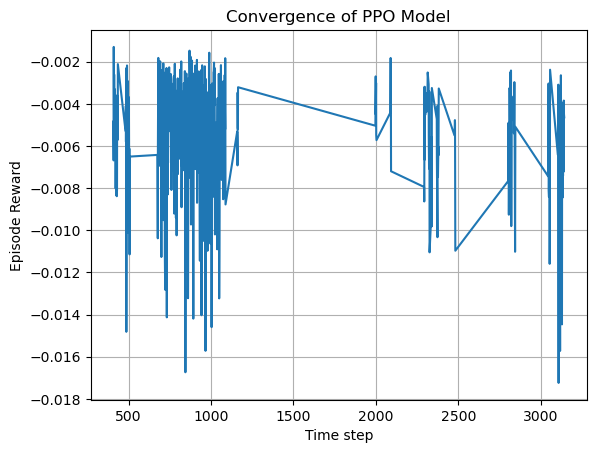

In [227]:
log_data = pd.read_csv(log_dir + "monitor.csv", skiprows=1)

# Print the first few rows to check available columns
print(log_data.head())
print("Log data shape:", log_data.shape)

# Check available column names
print("Columns in log file:", log_data.columns)

# Plot the convergence curve
plt.plot(log_data["t"], log_data["r"])  # "l" (length) vs "r" (reward)
plt.xlabel("Time step")
plt.ylabel("Episode Reward")
plt.title("Convergence of PPO Model")
plt.grid()
plt.show()



### Run a test

In [9]:
from gymnasium.wrappers import RecordEpisodeStatistics, RecordVideo
num_eval_episodes = 1

episode_over = False
rewards = list()
actions = list()
pnl = list()
obs, info = env.reset()
while not episode_over:
    action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
    obs, reward, terminated, truncated, info = env.step(action)
    rewards.append(reward)
    actions.append(action)
    pnl.append(info['P&L'])
    episode_over = terminated or truncated
env.close()

print(f'Example action taken: {actions}')
print(f'Episode rewards: {rewards}')

ValueError: I/O operation on closed file.

In [248]:
num_eval_episodes = 10

rewards_tot = list()
actions_tot = list()
pnl_tot = list()
obs, info = env.reset()
for i in range(num_eval_episodes):
    episode_over = False
    rewards = list()
    actions = list()
    pnl = list()
    obs, info = env.reset()
    while not episode_over:
        action, _states = model.predict(obs, deterministic=False)  # replace with actual agent
        obs, reward, terminated, truncated, info = env.step(action)
        rewards.append(reward)
        actions.append(action)
        pnl.append(info['P&L'])
        episode_over = terminated or truncated
    env.close()
    rewards_tot.append(rewards)
    actions_tot.append(actions)
    pnl_tot.append(pnl)

ValueError: I/O operation on closed file.

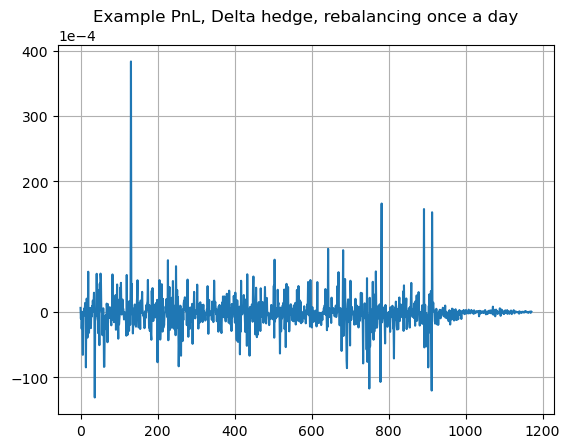

In [143]:
plt.figure(1)
plt.title("Example PnL, Delta hedge, rebalancing once a day")
plt.grid()
plt.ticklabel_format(axis='y', style='sci', scilimits=(-4,-4))
plt.plot(pnl_tot[9])

In [144]:
np.mean([np.percentile(i, 5) for i in pnl_tot])

np.float64(-0.0033025650885834326)

In [ ]:
def pnl_cva(path):
    pnl_without_hedge = np.zeros(len(path.CVA)-1)
    for i in range(1, len(path.CVA)):
        pnl_without_hedge[i-1] = path.CVA[i]-path.CVA[i-1]
    return pnl_without_hedge

pnl_without_hedge = [None]*len(paths)
for i in range(len(pnl_without_hedge)):
    pnl_without_hedge[i] = pnl_cva(paths[i])

plt.figure(2)
# Extract the 5% worst percentile values from each array
var_values_no_hedge = np.array([np.percentile(p,5) for p in pnl_without_hedge]) # is this really VaR?

var_values_no_hedge

TypeError: object of type 'numpy.float64' has no len()